In [2]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pandas_datareader import data as pdr
import datetime as dt

folder='Results'
os.makedirs(folder,exist_ok=True)


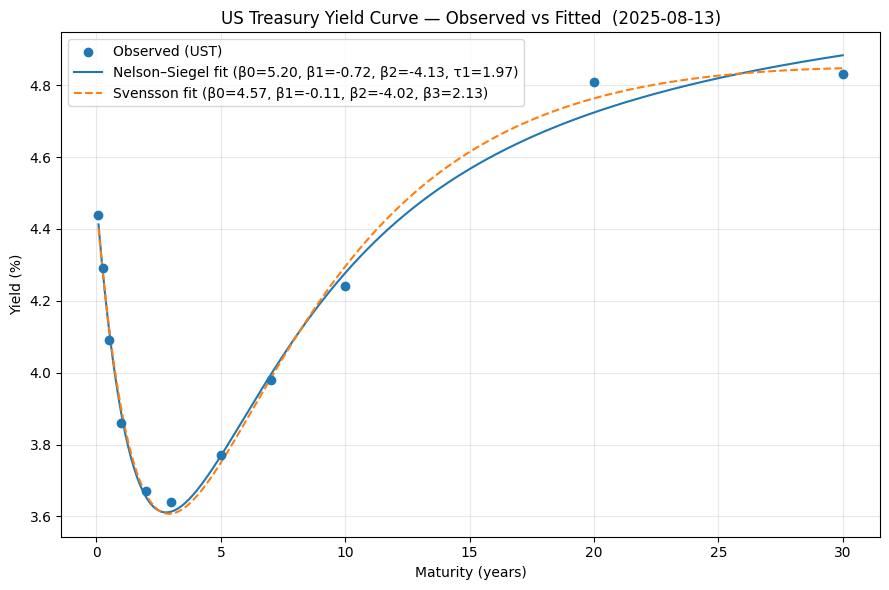


=== Curve Snapshot (2025-08-13): ===
1M     4.44
3M     4.29
6M     4.09
1Y     3.86
2Y     3.67
3Y     3.64
5Y     3.77
7Y     3.98
10Y    4.24
20Y    4.81
30Y    4.83
dtype: float64

Spreads:
  2s10s: 0.57 bps
  3m10y: -0.05 bps

Nelson–Siegel params: β0=5.2020, β1=-0.7198, β2=-4.1277, τ1=1.9736
Svensson params:     β0=4.5742, β1=-0.1074, β2=-4.0218, β3=2.1326, τ1=2.1547, τ2=10.0000

LinkedIn Caption:
 US Treasury curve on 2025-08-13: Deeply Inverted (3M>10Y). 2s10s spread = 0.6 bps, 3m10y = -0.0 bps. Fitted with Nelson–Siegel / Svensson.


In [3]:
# === Yield Curve Modeling: US Treasuries (Nelson–Siegel / Svensson) ===
# Requirements: pandas, numpy, matplotlib, scipy, pandas_datareader


# --------- CONFIG ---------
END = dt.date.today()
START = END - dt.timedelta(days=60)     # last ~2 months (enough to get a fresh business day)
TENORS_YEARS = {
    "1M": 1/12, "3M": 3/12, "6M": 6/12, "1Y": 1.0, "2Y": 2.0, "3Y": 3.0,
    "5Y": 5.0, "7Y": 7.0, "10Y": 10.0, "20Y": 20.0, "30Y": 30.0
}
# FRED tickers for US Treasury constant maturity yields
FRED_TICKERS = {
    "1M": "DGS1MO", "3M": "DGS3MO", "6M": "DGS6MO", "1Y": "DGS1",
    "2Y": "DGS2", "3Y": "DGS3", "5Y": "DGS5", "7Y": "DGS7",
    "10Y": "DGS10", "20Y": "DGS20", "30Y": "DGS30"
}

# --------- MODELS ---------
def nelson_siegel(m, beta0, beta1, beta2, tau1):
    """m in years; outputs yield in % (same scale as input)."""
    m = np.array(m, dtype=float)
    x = m / tau1
    # Avoid divide-by-zero around m=0
    with np.errstate(divide='ignore', invalid='ignore'):
        factor1 = (1 - np.exp(-x)) / np.where(x == 0, 1e-12, x)
    return beta0 + beta1 * factor1 + beta2 * (factor1 - np.exp(-x))

def svensson(m, beta0, beta1, beta2, beta3, tau1, tau2):
    """Svensson extension (optional)."""
    m = np.array(m, dtype=float)
    x1 = m / tau1
    x2 = m / tau2
    with np.errstate(divide='ignore', invalid='ignore'):
        f1 = (1 - np.exp(-x1)) / np.where(x1 == 0, 1e-12, x1)
        f2 = (1 - np.exp(-x2)) / np.where(x2 == 0, 1e-12, x2) - np.exp(-x2)
    return beta0 + beta1 * f1 + beta2 * (f1 - np.exp(-x1)) + beta3 * f2

# --------- DATA FETCH (FRED) + CLEAN ---------
def fetch_latest_curve():
    df = pd.DataFrame()
    for label, ticker in FRED_TICKERS.items():
        s = pdr.DataReader(ticker, "fred", START, END).rename(columns={ticker: label})
        df = pd.concat([df, s], axis=1)
    df = df.dropna().iloc[-1:]  # last complete row
    if df.empty:
        raise ValueError("No complete row of yields available from FRED.")
    date = df.index[0].date()
    yields_pct = df.iloc[0].to_dict()  # dict of label -> yield%
    return date, yields_pct

try:
    curve_date, ydict = fetch_latest_curve()
except Exception as e:
    print("FRED fetch failed, falling back to example yields. Error:", e)
    # Fallback example (replace with your own if desired) – in %
    curve_date = dt.date(2025, 8, 14)
    ydict = {"1M": 5.25, "3M": 5.30, "6M": 5.20, "1Y": 4.95, "2Y": 4.60, "3Y": 4.40,
             "5Y": 4.20, "7Y": 4.10, "10Y": 4.05, "20Y": 4.25, "30Y": 4.15}

# Build arrays for fitting
mats = []
yields_pct = []
for k, m in TENORS_YEARS.items():
    if k in ydict and pd.notna(ydict[k]):
        mats.append(m)
        yields_pct.append(ydict[k])
mats = np.array(mats, dtype=float)
yields_pct = np.array(yields_pct, dtype=float)

# Sort by maturity
order = np.argsort(mats)
mats, yields_pct = mats[order], yields_pct[order]

# --------- FIT NELSON–SIEGEL ---------
# Heuristic initial guesses & bounds (helps stability)
beta0_0 = yields_pct[-1]                         # long-term level ~ 30Y
beta1_0 = yields_pct[0] - yields_pct[-1]         # short-vs-long slope
beta2_0 = 0.1                                    # curvature small start
tau1_0  = 1.5                                    # 1–3y often reasonable
p0_ns = [beta0_0, beta1_0, beta2_0, tau1_0]
bounds_ns = ([-5, -10, -10, 0.05], [15, 10, 10, 10])  # yields in %, tau>0

pars_ns, _ = curve_fit(nelson_siegel, mats, yields_pct, p0=p0_ns, bounds=bounds_ns, maxfev=100000)
beta0, beta1, beta2, tau1 = pars_ns

# Optional: FIT SVENSSON (comment out if you only want NS)
use_svensson = True
if use_svensson:
    beta3_0, tau2_0 = 0.05, 4.0
    p0_sv = [beta0, beta1, beta2, beta3_0, tau1, tau2_0]
    bounds_sv = ([-5, -10, -10, -10, 0.05, 0.05], [15, 10, 10, 10, 10, 10])
    pars_sv, _ = curve_fit(svensson, mats, yields_pct, p0=p0_sv, bounds=bounds_sv, maxfev=200000)

# --------- PLOTS ---------
xgrid = np.linspace(1/12, 30, 500)  # 1M to 30Y
y_ns = nelson_siegel(xgrid, *pars_ns)
if use_svensson:
    y_sv = svensson(xgrid, *pars_sv)

plt.figure(figsize=(9,6))
plt.scatter(mats, yields_pct, label="Observed (UST)", zorder=3)
plt.plot(xgrid, y_ns, label=f"Nelson–Siegel fit (β0={beta0:.2f}, β1={beta1:.2f}, β2={beta2:.2f}, τ1={tau1:.2f})")
if use_svensson:
    b0,b1,b2,b3,t1,t2 = pars_sv
    plt.plot(xgrid, y_sv, linestyle="--", label=f"Svensson fit (β0={b0:.2f}, β1={b1:.2f}, β2={b2:.2f}, β3={b3:.2f})")
plt.title(f"US Treasury Yield Curve — Observed vs Fitted  ({curve_date.isoformat()})")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
file_path=os.path.join(folder, f"yield_curve_{curve_date.isoformat()}.png")
plt.savefig(file_path,bbox_inches='tight', dpi=300)
plt.show()

# --------- DIAGNOSTICS & ONE-LINER FOR YOUR POST ---------
# Key spreads:
# find nearest available for 2Y, 10Y, 3M
def nearest(label):
    return ydict.get(label, np.nan)

y_3m = nearest("3M")
y_2y = nearest("2Y")
y_10y = nearest("10Y")

spread_2s10s = y_10y - y_2y if (pd.notna(y_10y) and pd.notna(y_2y)) else np.nan
spread_3m10y = y_10y - y_3m if (pd.notna(y_10y) and pd.notna(y_3m)) else np.nan

# simple classification
curve_type = "Inverted" if (pd.notna(spread_2s10s) and spread_2s10s < 0) else "Upward/Normal"
if pd.notna(spread_3m10y) and spread_3m10y < 0:
    curve_type = "Deeply Inverted (3M>10Y)"

print("\n=== Curve Snapshot ({}): ===".format(curve_date))
print(pd.Series(ydict))
print("\nSpreads:")
print(f"  2s10s: {spread_2s10s:.2f} bps" if pd.notna(spread_2s10s) else "  2s10s: n/a",
      "\n", f"  3m10y: {spread_3m10y:.2f} bps" if pd.notna(spread_3m10y) else "  3m10y: n/a", sep="")
print("\nNelson–Siegel params: β0={:.4f}, β1={:.4f}, β2={:.4f}, τ1={:.4f}".format(*pars_ns))
if use_svensson:
    print("Svensson params:     β0={:.4f}, β1={:.4f}, β2={:.4f}, β3={:.4f}, τ1={:.4f}, τ2={:.4f}".format(*pars_sv))

# One-liner for LinkedIn caption:
caption = (
    f"US Treasury curve on {curve_date}: {curve_type}. "
    f"2s10s spread = {spread_2s10s:.1f} bps, 3m10y = {spread_3m10y:.1f} bps. "
    "Fitted with Nelson–Siegel" + (" / Svensson." if use_svensson else ".")
)
print("\nLinkedIn Caption:\n", caption)


C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_9876\2348297618.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  df['lol']=np.random.random_integers(1,2, size=len(df))
C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_9876\2348297618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lol'].replace(1,5, inplace=True)


10